## Correlation Between Global Temperature and Tornado History Data
I have combined, cleaned, and structured historical tornado and average global temperature data in this notebook, and I have [visualized it in Tableau](https://public.tableau.com/app/profile/david.branson/viz/GlobalTemperatureTornadoFrequencyCorrelation/Dashboard1).

**Tornado data from [NOAA](https://www.ncei.noaa.gov/access/monitoring/tornadoes/):**
Tornado statistics for the Contiguous U.S. are provided by the [Storm Prediction Center (SPC)](https://www.spc.noaa.gov/climo/online/monthly/newm.html) and are available from December 1950—May 2023. Additional information can be found in the [Monthly Tornado Report](https://www.ncei.noaa.gov/monthly-report/tornadoes) and [Tornado Count Methodology](https://www.ncei.noaa.gov/access/dyk/tornadocount).

**Global Temperature data is from [datahub](https://datahub.io/core/global-temp#data)**.
I did some initial structuring of this data in Excel.


### Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import datetime as dt
import statsmodels.api as sm



### Load and Format Data
This code block:
- Loads the tornado and temperature data from .csv files
- Formats the date columns in each set to match
- Drops preliminary data that hasn't been made official
- Sets data type for all numerical data to integer 32
- Drops rows with duplicate dates
- Drops original date columns and other unneeded data
- Merges the two datasets into one

In [2]:
# Read and clean Tordado data

tornado_df = pd.read_csv('data.csv')

# split year and month
tornado_df['Year'] = tornado_df['Date'].astype(str).str[:4]
tornado_df['Month'] = tornado_df['Date'].astype(str).str[-2:]

# Drop original "date" column
tornado_df.drop(columns = ["Date"], inplace = True)

# Drop preliminary data (rows with asterisks)
tornado_df = tornado_df[tornado_df['Tornadoes'].str[-1:] != '*']

# convert all columns to int32
tornado_df['Month'] = tornado_df['Month'].astype('int32')
tornado_df['Year'] = tornado_df['Year'].astype('int32')
tornado_df['Tornadoes'] = tornado_df['Tornadoes'].astype('int32')
tornado_df['Fatalities'] = tornado_df['Fatalities'].astype('int32')

# Read and clean temperature data
temp_df = pd.read_csv('monthly_temps.csv')
temp_df.dropna(inplace = True)
temp_df.drop(columns = ['Source'], inplace=True)
temp_df.drop_duplicates(subset='Date')

# split year and month
temp_df['Date'] = pd.to_datetime(temp_df['Date'])
temp_df['Year'] = temp_df['Date'].dt.year
temp_df['Month'] = temp_df['Date'].dt.month

# drop original date column
temp_df.drop(columns = ['Date'], inplace=True)

# rename "mean" column to "Temp"
temp_df.rename(columns = {'Mean':'Temp'}, inplace=True)

# Join Temp and Tornado data

df = pd.merge(tornado_df, temp_df)
df

,Tornadoes,Fatalities,Year,Month,Temp
0,201,70,1950,12,-0.1810
1,196,69,1951,1,-0.2903
2,186,25,1951,2,-0.4101
3,171,24,1951,3,-0.1689
4,182,14,1951,4,-0.0877
...,...,...,...,...,...
788,1087,38,2016,8,0.8998
789,1089,38,2016,10,0.7292
790,1089,38,2016,10,0.8767
791,1040,44,2016,11,0.7504


### Export joined dataframes for use in Tableau
You can view the Tableau dashboard [here](https://public.tableau.com/app/profile/david.branson/viz/GlobalTemperatureTornadoFrequencyCorrelation/Dashboard1).

In [3]:
df.to_csv('temp_and_tornadoes.csv',index = False)

### Visualize data

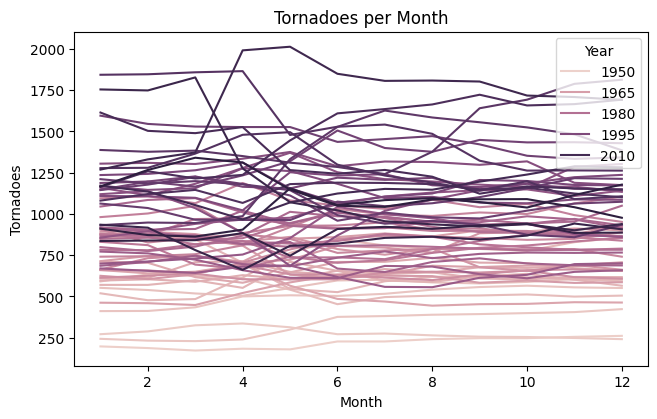

In [4]:
sns.lineplot(data = df, x = 'Month', y = 'Tornadoes', hue = 'Year')
# plt.tight_layout()
plt.title('Tornadoes per Month')
plt.gcf().set_size_inches(7.4,4.34)
plt.savefig('tornado_count_plot.png', dpi=150)

### Look for correlations

<Axes: >

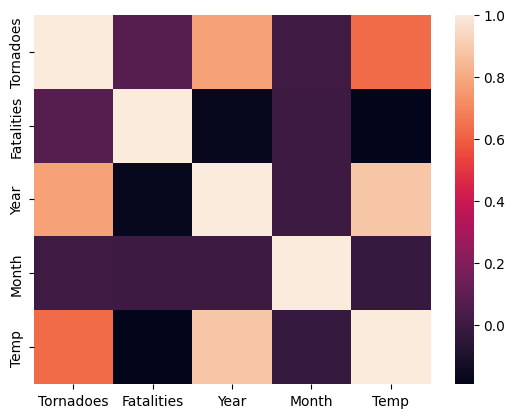

In [5]:
correlation_table = df.corr()
correlation_table
sns.heatmap(correlation_table)

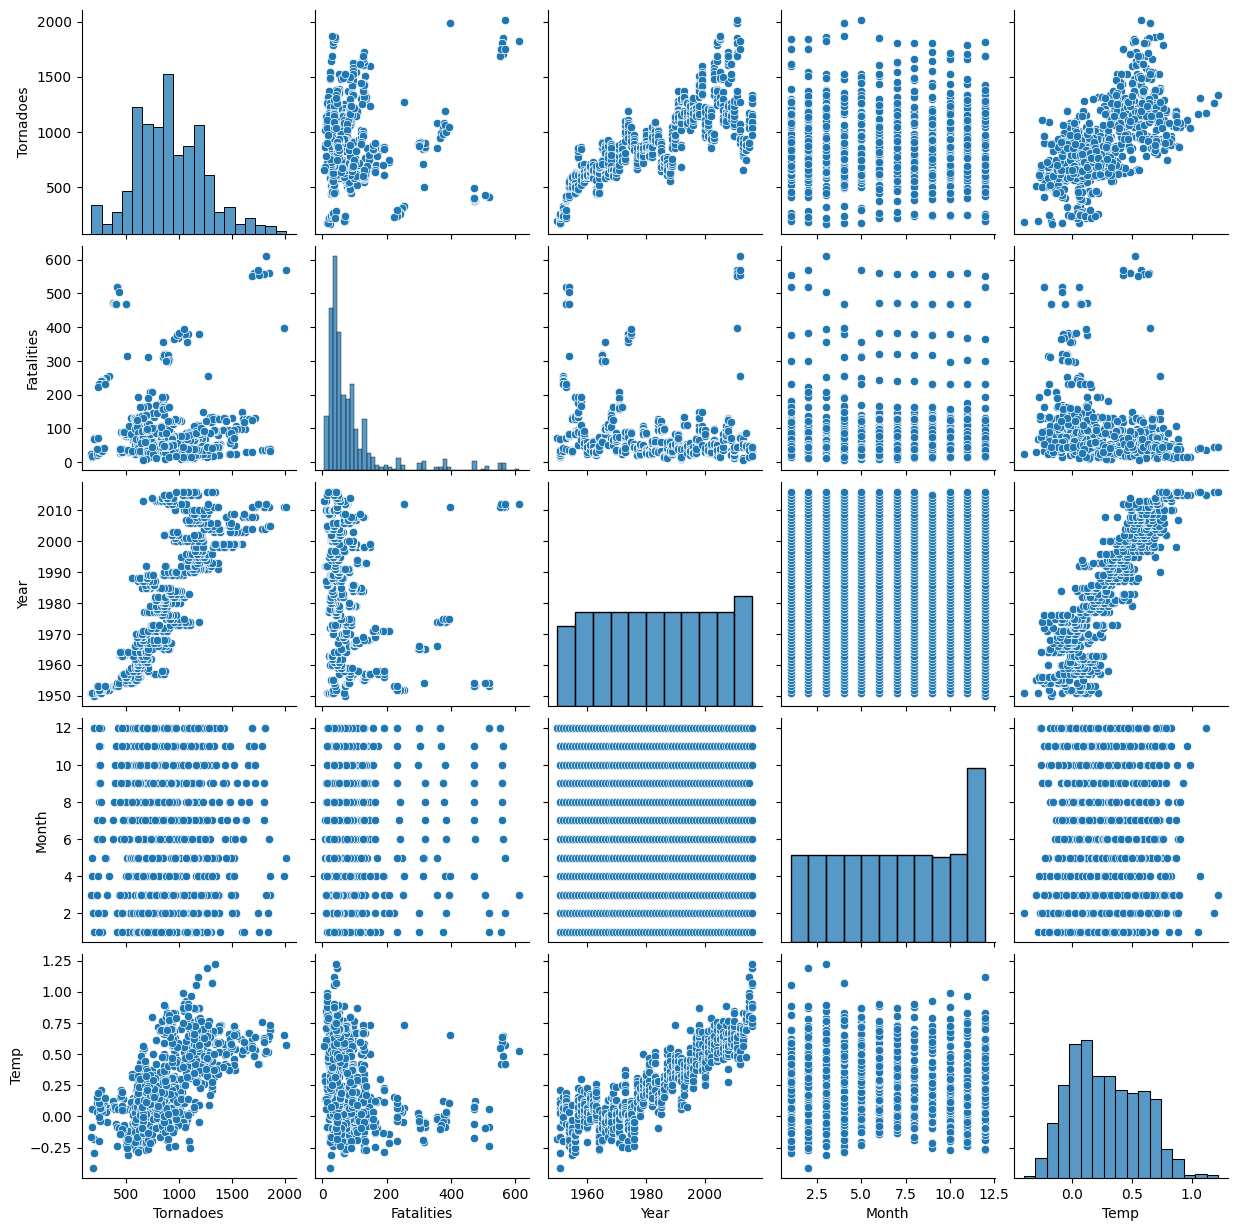

In [6]:
sns.pairplot(df)

### Make months categorical

In [7]:
# create dummies
df = pd.get_dummies(df, columns = ['Month'], dtype = int)


### Create Linear Regression 

In [8]:

# Split data
X = df.drop(columns = ['Tornadoes', 'Fatalities'])
y = df['Tornadoes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)




# create model https://towardsdatascience.com/linear-regression-in-6-lines-of-python-5e1d0cd05b8d
model = LinearRegression()
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

intercept = model.intercept_
coeff = model.coef_
score = model.score(X,y)
features = model.feature_names_in_
print('intercept: ', intercept)
print('coefficients: ', coeff)
print('features: ', features)
print('score:', score)

intercept:  -33206.21827781799
coefficients:  [  17.24827406 -305.37851587   -1.15139305   11.24269521   15.87467018
   14.24941814   21.93219416    0.4435218   -24.96396674   -6.72942887
  -10.98865222   -8.68779268   -7.43674601   -3.78451993]
features:  ['Year' 'Temp' 'Month_1' 'Month_2' 'Month_3' 'Month_4' 'Month_5' 'Month_6'
 'Month_7' 'Month_8' 'Month_9' 'Month_10' 'Month_11' 'Month_12']
score: 0.6084240976868094


### Evaluate Model

In [9]:
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("R squared: ", r2)
print("MSE: ", mse)

R squared:  0.596175942300674
MSE:  45030.30537789866


### Visualize Model Quality

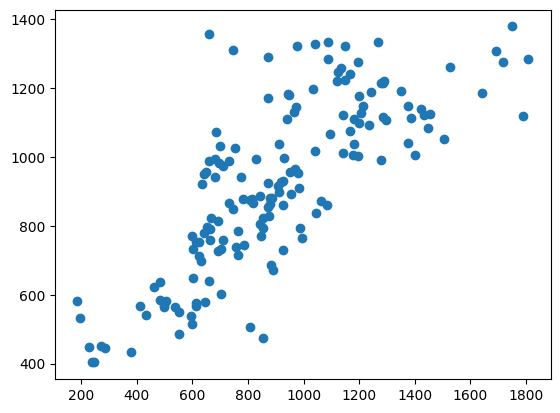

In [10]:
plt.scatter(y_test, y_pred)
# plt.plot(X, y_pred, color='red')
plt.show()

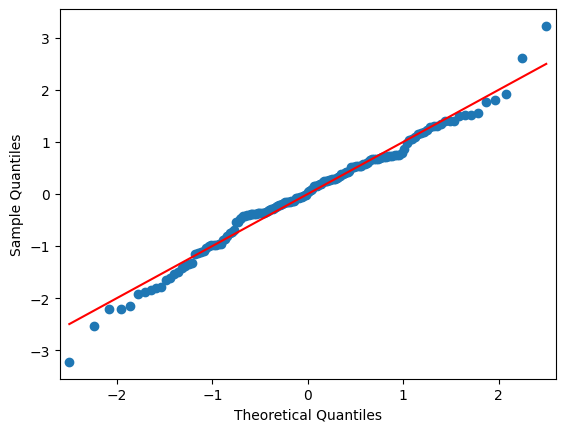

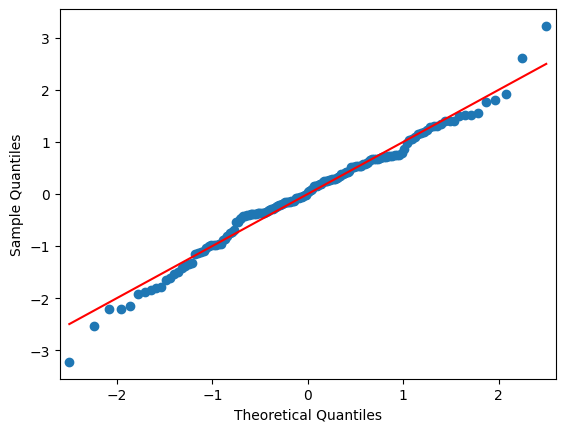

In [11]:
errors = y_pred - y_test
sm.qqplot(errors, line='s', fit = True)
